## Dog Breed Prediction

In this project, we will see how to use Keras and TensorFlow to build, train, and test a Convolutional Neural Network capable of identifying the breed of a dog in a supplied image. This is a supervised learning problem, specifically a multiclass classification problem.

We will start by connecting to Kaggle using Kaggle API which can be downloaded from your Kaggle account's settings and uploading it here(upload box).

In [5]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

In [6]:
!kaggle datasets list


ref                                                           title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
saidaminsaidaxmadov/chocolate-sales                           Chocolate Sales                                      468320  2026-01-04 14:23:35.490000          14137        249                1  
vishardmehta/gold-price-forecasting-dataset                   Gold Price Forecasting Dataset                       138149  2026-02-02 10:27:21.830000           1142         25                1  
aliiihussain/amazon-sales-dataset                             Amazon_Sales_Dataset                                1297759  2026-02-01 11:37:12.353000           1969         44                1  
rockyt07/social-media-use

In [7]:
# The Kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
import os

os.makedirs("dog_dataset", exist_ok=True)
os.chdir("dog_dataset")

print("Current directory:", os.getcwd())


Current directory: d:\DATA SCIENCE PROJECTS\Dog Breed Prediction\dog_dataset


In [9]:
import os
os.system("kaggle datasets list -s dogbreedidfromcomp")


0

In [10]:
import os

os.system("kaggle datasets download catherinehorng/dogbreedidfromcomp")
os.chdir("..")


In [11]:
import zipfile
import os

zip_path = "dog_dataset/dogbreedidfromcomp.zip"
extract_path = "dog_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.remove(zip_path)
os.remove("dog_dataset/sample_submission.csv")


In [12]:
# Important library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

c:\NEW FOLDER\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [13]:
# Read the labels.csv file and checking shape and records
labels_all = pd.read_csv("dog_dataset/labels.csv")
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [14]:
# Visualize the number of each breeds
breeds_all = labels_all["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: count, dtype: int64

In [15]:
labels_all["breed"].value_counts()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
komondor                 67
brabancon_griffon        67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64

In [16]:
CLASS_NAMES =np.unique(labels_all["breed"])

In [17]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels_all), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels_all['breed'], classes = CLASS_NAMES)

# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels_all))):
    img = image.load_img('dog_dataset/train/%s.jpg' % labels_all['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.0

# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

100%|██████████| 10222/10222 [00:25<00:00, 399.96it/s]


Train Images shape:  (10222, 224, 224, 3)  size: 1,538,697,216
One-hot encoded output shape:  (10222, 120)  size: 1,226,640


In [18]:
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam

base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze pretrained layers
for layer in base.layers:
    layer.trainable = False

model = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(CLASS_NAMES), activation='softmax')
])

model.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │        30,840 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,616,760 (9.98 MB)

 Trainable params: 358,776 (1.37 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(
    X_data, Y_data, test_size=0.1, random_state=42
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_and_val, Y_train_and_val, test_size=0.2, random_state=42
)

In [20]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

epochs = 20
batch_size = 32

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    min_lr=1e-6
)

history = model.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 77s 315ms/step - accuracy: 0.0529 - loss: 4.5794 - val_accuracy: 0.2402 - val_loss: 3.9492 - learning_rate: 1.0000e-04
Epoch 2/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 70s 303ms/step - accuracy: 0.2295 - loss: 3.5205 - val_accuracy: 0.4668 - val_loss: 2.7513 - learning_rate: 1.0000e-04
Epoch 3/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 71s 308ms/step - accuracy: 0.3867 - loss: 2.6316 - val_accuracy: 0.5679 - val_loss: 1.9923 - learning_rate: 1.0000e-04
Epoch 4/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 69s 300ms/step - accuracy: 0.4872 - loss: 2.0850 - val_accuracy: 0.6250 - val_loss: 1.6044 - learning_rate: 1.0000e-04
Epoch 5/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 69s 298ms/step - accuracy: 0.5421 - loss: 1.7617 - val_accuracy: 0.6560 - val_loss: 1.3862 - learning_rate: 1.0000e-04
Epoch 6/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 69s 301ms/step - accuracy: 0.5851 - loss: 1.5539 - val_accuracy: 0.6723 - val_loss: 1.2704 - learning_rate: 1.0000e-04
Epoch 7/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 71s 30

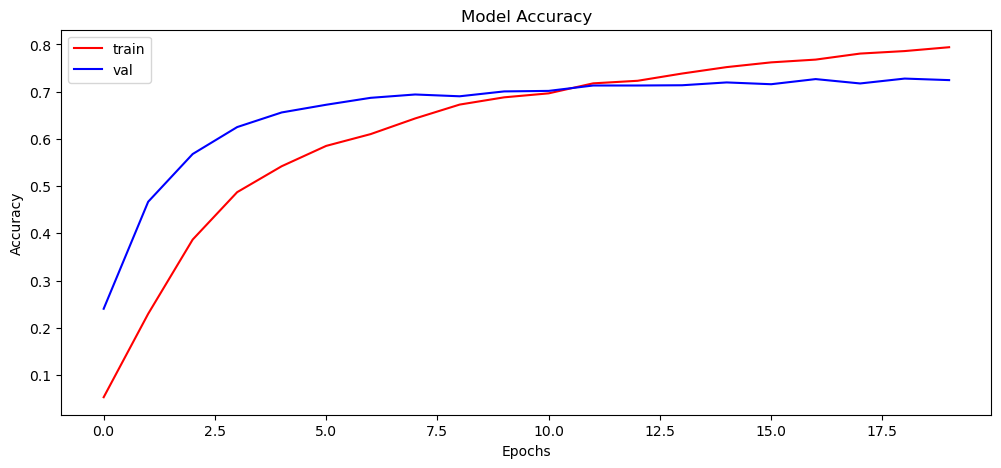

In [21]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

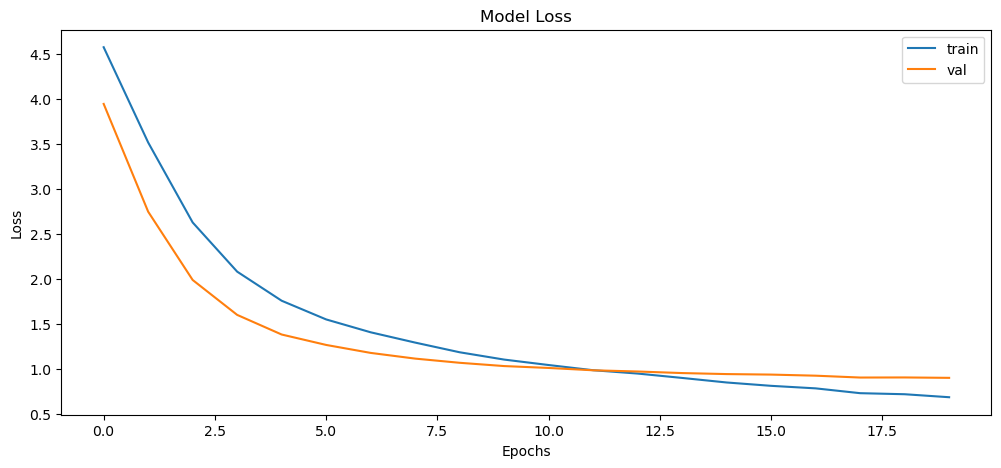

In [22]:
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','val'])
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 275ms/step

Test Accuracy:  72.53 %

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       0.88      0.78      0.82         9
           2       1.00      0.91      0.95        11
           3       0.67      0.50      0.57        12
           4       0.20      0.20      0.20         5
           5       0.50      0.50      0.50         8
           6       0.58      0.58      0.58        12
           7       0.67      0.75      0.71         8
           8       0.60      0.50      0.55         6
           9       0.75      0.90      0.82        10
          10       1.00      0.94      0.97        18
          11       0.86      0.80      0.83        15
          12       0.71      0.83      0.77         6
          13       0.88      0.93      0.90        15
          14       0.75      0.60      0.67        10
          15       0.67      0.60      0.63

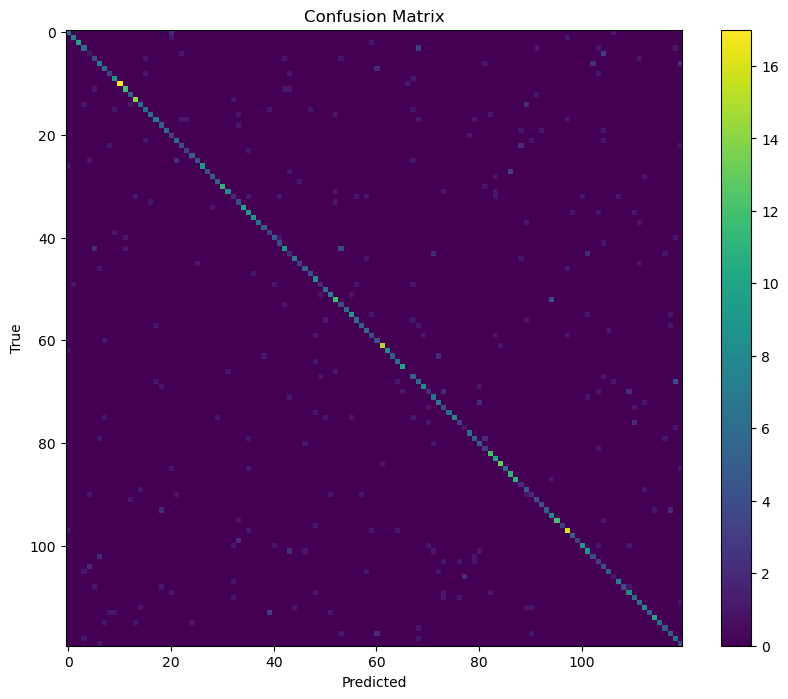

In [23]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Predict probabilities
Y_pred = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Evaluate model
score = model.evaluate(X_test, Y_test, verbose=0)

print("\nTest Accuracy: ", round(score[1]*100, 2), "%")

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,8))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [25]:
import os

os.makedirs("model", exist_ok=True)

model.save("model/dog_breed_model.keras")

print("Model saved successfully")


Model saved successfully
